<a href="https://colab.research.google.com/github/aliasgharchakera/GPU-Spring24-Assignment01/blob/main/AY06993_Assgn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-tyd8ji39
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-tyd8ji39
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5cd225851b7638f3f6d55a19328295f16c014079
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.0.3-py3-none-any.whl size=7432 sha256=ad99cf1e6175f37f13398802e9e82d42885745e385f9d1c2ce678f3d359f3a95
  Stored in directory: /tmp/pip-ephem-wheel-cache-ygr95u2e/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Source files will be saved in "/tmp/tmp172crgbk".


In [3]:
!nvidia-smi

Sat Jan 27 07:29:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [24]:
%%cuda
#include <stdio.h>
#include <curand_kernel.h>
#include <time.h>

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

__global__ void InitData(int* data, const int N)
{
    curandState_t state;
    curand_init(clock64(), 0, 0, &state);
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx < N) {
        data[idx] = curand(&state) % 100;
    }
}

int main()
{
  int* h_data = 0;
  int* d_data = 0;
  clock_t start = 0;

  const int sizes[] = {1000, 10000, 100000, 1000000}; // Different values of N
  const int numSizes = 4;
  double cpuTimes[numSizes];
  double gpuTimes[numSizes];
  double copyTimes[numSizes];

  //allocate memory on device
  cudaMalloc((void **)&d_data, 10*sizeof(int));

  InitData<<<1, 10>>>(d_data, 10);
  checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
  cudaFree(d_data);
  // Open a file for writing
  FILE *f = fopen("init_timings.txt", "w");
  if (f == NULL) {
      printf("Error opening file!\n");
      return 1;
  }

  // Different execution configurations
  const int threadConfigs[] = {32, 64, 128, 256, 512};
  const int numConfigs = 5;

  for (int c = 0; c < numConfigs; ++c) {
    int numThreadsPerBlock = threadConfigs[c];

    for (int s = 0; s < numSizes; ++s) {
      const int N = sizes[s];
      int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);
      size_t size = N * sizeof(int);

      h_data = (int*)malloc(size);
      //calculate on host
      start = clock();
      for (int i = 0; i < N; i++) {
          h_data[i] = rand() % 100;
      }
      cpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

      //allocate memory on device
      cudaMalloc((void **)&d_data, size);

      //calculate on device
      start = clock();
      InitData<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_data, N);
      checkCudaErr(cudaDeviceSynchronize(), "Syncronization");
      gpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

      //copy device data to host memory
      start = clock();
      checkCudaErr(cudaMemcpy(h_data, d_data, N*sizeof(int), cudaMemcpyDeviceToHost), "cudaMemcpy D->H");
      copyTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

      //release memory
      cudaFree(d_data);
      free(h_data);

      // Write to file
      fprintf(f, "%d\t%d\t%d\t%f\t%f\t%f\n", N, numThreadsPerBlock, numBlocksPerGrid, cpuTimes[s], gpuTimes[s], copyTimes[s]);
    }
  }

  fclose(f);

  return 0;
}

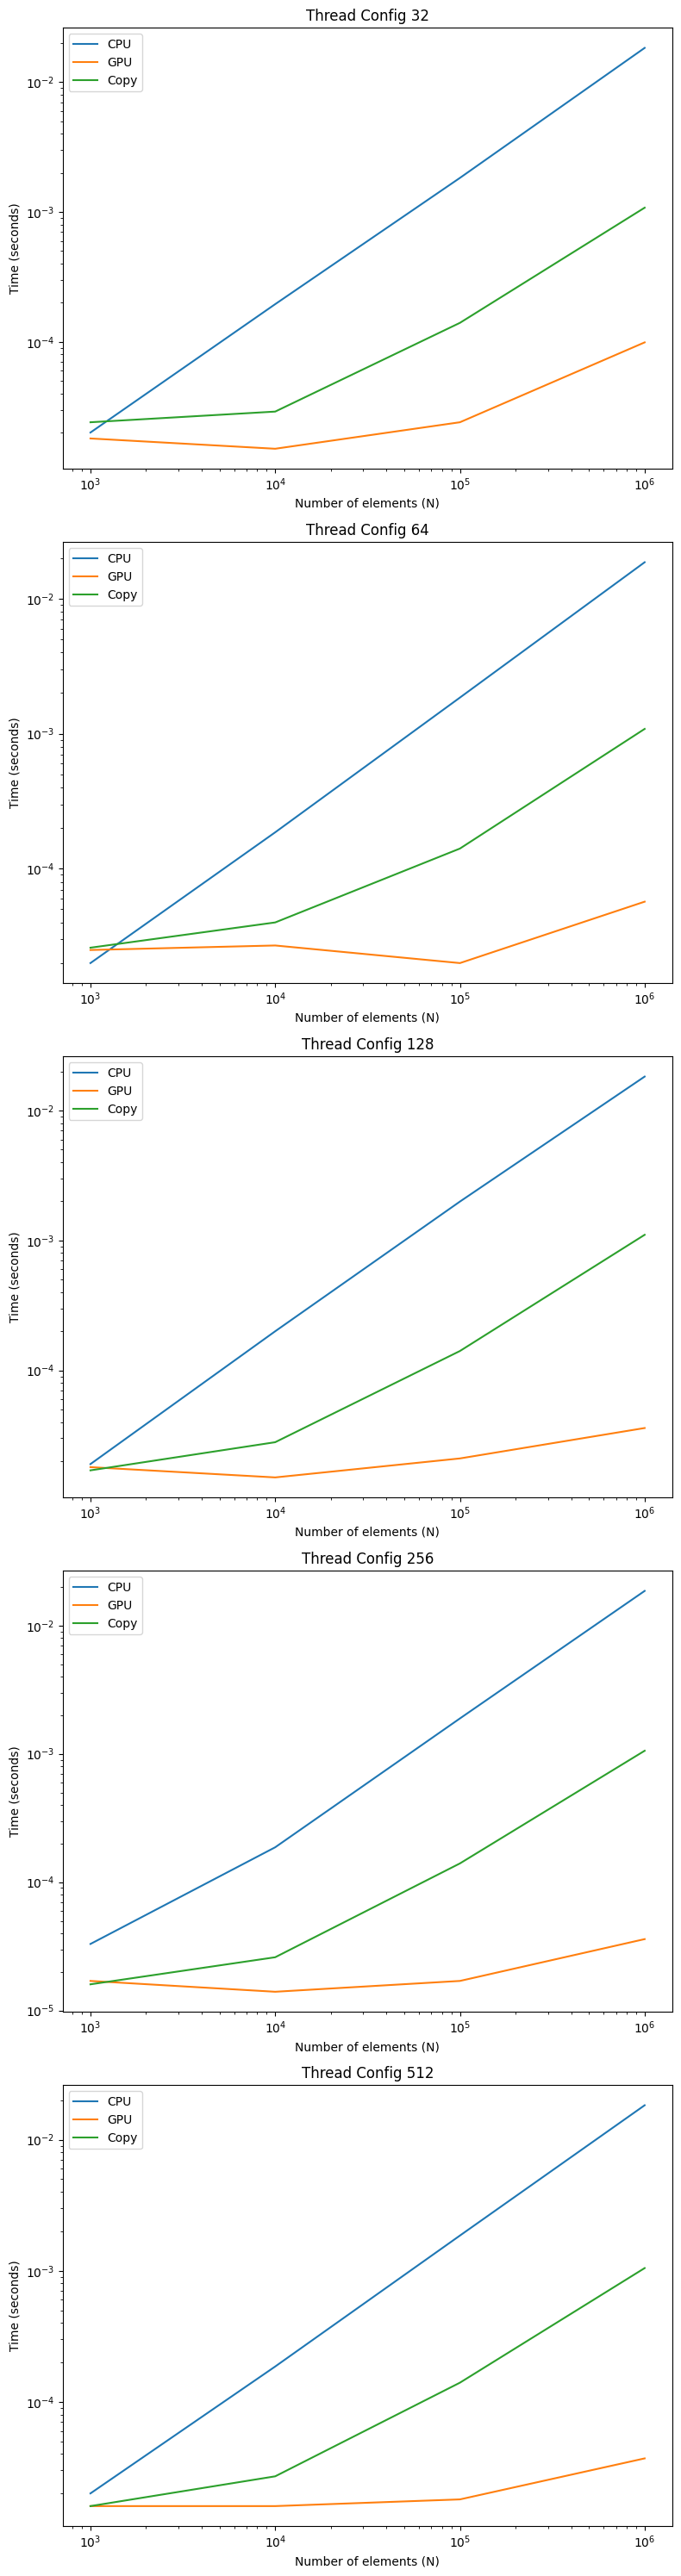

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Read the timing results from the file
with open('init_timings.txt') as f:
    data = f.readlines()

# Parse the data
sizes = []
thread_configs = []
num_blocks_per_grids = []
cpu_times = []
gpu_times = []
copy_times = []
for line in data:
    line = line.strip()
    values = line.split('\t')
    sizes.append(int(values[0]))
    thread_configs.append(int(values[1]))
    num_blocks_per_grids.append(int(values[2]))
    cpu_times.append(float(values[3]))
    gpu_times.append(float(values[4]))
    copy_times.append(float(values[5]))

# Create a color map for different thread configs
color_map = plt.get_cmap('tab10')

# Get unique thread configs
unique_thread_configs = (list(set(thread_configs)))
unique_thread_configs.sort()

# Create subplots for each thread config
fig, axs = plt.subplots(len(unique_thread_configs), 1, figsize=(8, 6 * len(unique_thread_configs)))

# Plot for each thread config
for i, config in enumerate(unique_thread_configs):
    indices = [j for j, x in enumerate(thread_configs) if x == config]
    ax = axs[i]
    ax.plot(np.array(sizes)[indices], np.array(cpu_times)[indices], label='CPU', color=color_map(0))
    ax.plot(np.array(sizes)[indices], np.array(gpu_times)[indices], label='GPU', color=color_map(1))
    ax.plot(np.array(sizes)[indices], np.array(copy_times)[indices], label='Copy', color=color_map(2))
    ax.set_xlabel('Number of elements (N)')
    ax.set_ylabel('Time (seconds)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Thread Config {config}')
    ax.legend(loc='upper left')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [25]:
%%cuda
#include <stdio.h>
#include <time.h>

__global__ void sum(int* a, int* b, int* c, const int N) {
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    if (i<N) {
        c[i] = a[i] + b[i];
    }
}

void sum_host(int* a, int* b, int* c, const int N) {
    for (int i = 0; i < N; ++i) {
        c[i] = a[i] + b[i];
    }
}

int main() {
    int* h_a = 0;
    int* h_b = 0;
    int* h_c = 0;

    int* d_a = 0;
    int* d_b = 0;
    int* d_c = 0;

    const int sizes[] = {1000, 10000, 100000, 1000000}; // Different values of N
    const int numSizes = 4;
    double cpuTimes[numSizes];
    double gpuTimes[numSizes];

		//Get the gpu up and running, since the first call usually takes some overhead time to start
		//allocate device memory
		cudaMalloc((void**)&d_a, 10*sizeof(int));
		cudaMalloc((void**)&d_b, 10*sizeof(int));
		cudaMalloc((void**)&d_c, 10*sizeof(int));

		sum<<<1, 10>>>(d_a, d_b, d_c, 10);
		cudaDeviceSynchronize();

		//delete data allocated on device
		cudaFree(d_a);
		cudaFree(d_b);
		cudaFree(d_c);

		// Open a file for writing
    FILE *f = fopen("sum_timings.txt", "w");
    if (f == NULL) {
        printf("Error opening file!\n");
        return 1;
    }

		// Different execution configurations
    const int threadConfigs[] = {32, 64, 128, 256, 512};
    const int numConfigs = 5;

		for (int c = 0; c < numConfigs; ++c) {
      int numThreadsPerBlock = threadConfigs[c];

			for (int s = 0; s < numSizes; ++s) {
				const int N = sizes[s];
				int numBlocksPerGrid = ceilf(N/numThreadsPerBlock + 1);
				size_t size = N * sizeof(int);

				//allocate host memory
				h_a = (int*)malloc(size);
				h_b = (int*)malloc(size);
				h_c = (int*)malloc(size);

				//allocate device memory
				cudaMalloc((void**)&d_a, size);
				cudaMalloc((void**)&d_b, size);
				cudaMalloc((void**)&d_c, size);

				//calculate on host
				clock_t start = clock();
				sum_host(h_a, h_b, h_c, N);
				cpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//calculate on device
				start = clock();
				sum<<<numBlocksPerGrid, numThreadsPerBlock>>>(d_a, d_b, d_c, N);
				cudaDeviceSynchronize();
				gpuTimes[s] = (double)(clock() - start) / CLOCKS_PER_SEC;

				//copy result from device to host
				cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);

				//delete data allocated on device
				cudaFree(d_a);
				cudaFree(d_b);
				cudaFree(d_c);

				//delete host memory
				free(h_a);
				free(h_b);
				free(h_c);

				// Write the results to the file
				fprintf(f, "%d\t%d\t%d\t%f\t%f\n", sizes[s], numThreadsPerBlock, numBlocksPerGrid, cpuTimes[s], gpuTimes[s]);
			}
		}

    // Close the file
    fclose(f);
    return 0;
}


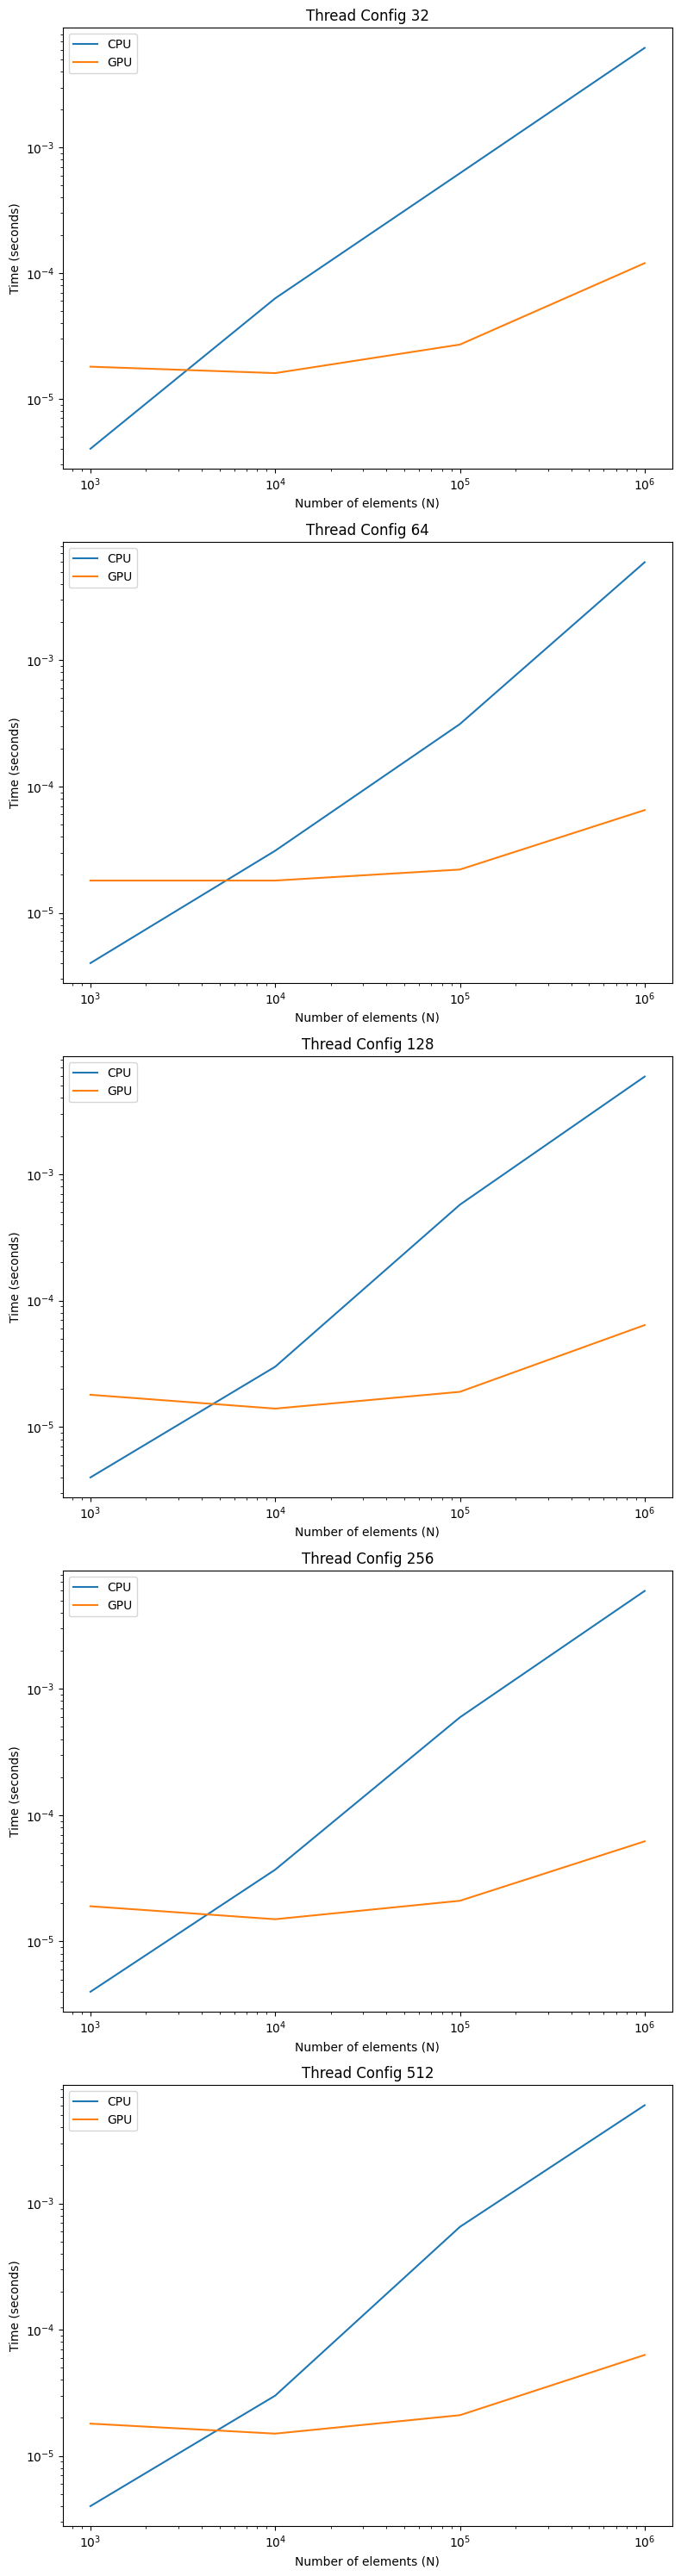

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Read the timing results from the file
with open('sum_timings.txt') as f:
    data = f.readlines()

# Parse the data
sizes = []
thread_configs = []
num_blocks_per_grids = []
cpu_times = []
gpu_times = []
for line in data:
    line = line.strip()
    values = line.split('\t')
    sizes.append(int(values[0]))
    thread_configs.append(int(values[1]))
    num_blocks_per_grids.append(int(values[2]))
    cpu_times.append(float(values[3]))
    gpu_times.append(float(values[4]))

# Create a color map for different thread configs
color_map = plt.get_cmap('tab10')

# Get unique thread configs
unique_thread_configs = (list(set(thread_configs)))
unique_thread_configs.sort()

# Create subplots for each thread config
fig, axs = plt.subplots(len(unique_thread_configs), 1, figsize=(8, 6 * len(unique_thread_configs)))

# Plot for each thread config
for i, config in enumerate(unique_thread_configs):
    indices = [j for j, x in enumerate(thread_configs) if x == config]
    ax = axs[i]
    ax.plot(np.array(sizes)[indices], np.array(cpu_times)[indices], label='CPU', color=color_map(0))
    ax.plot(np.array(sizes)[indices], np.array(gpu_times)[indices], label='GPU', color=color_map(1))
    ax.set_xlabel('Number of elements (N)')
    ax.set_ylabel('Time (seconds)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Thread Config {config}')
    ax.legend(loc='upper left')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
